# 准备软件包

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases
from dnn_utils import sigmoid,sigmoid_backward,relu,relu_backward
import lr_utils

In [2]:
np.random.seed(1)

# 初始化参数

L层的神经网络的参数初始化，我们只需要知道每一层的节点数量就可实现参数的初始化。

In [3]:
def initialize_parameters_deep(layers_dims):
    """
    初始化多层的神经网络参数
    
    参数：
        layers_dims - 神经网络每一层的节点数
        
    返回：
        parameters - 包含参数“W1”，“b1”，...，“WL”，“bL”的字典
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1,L):
        parameters["W"+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) / np.sqrt(layers_dims[l-1]) 
#         parameters["W"+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * 0.01
        parameters["b"+str(l)] = np.zeros((layers_dims[l],1))
        
        assert(parameters["W"+str(l)].shape == (layers_dims[l],layers_dims[l-1]))
        assert(parameters["b"+str(l)].shape == (layers_dims[l],1))
        
    return parameters

测试一下initialize_parameters_deep函数：

In [4]:
print("==============测试initialize_parameters_deep==============")
layers_dims = [5,4,3]
parameters = initialize_parameters_deep(layers_dims)
for l in range(1,len(layers_dims)):
    print("W"+str(l) +" = " + str(parameters["W"+str(l)]))
    print("b"+str(l) +" = " + str(parameters["b"+str(l)]))

==============测试initialize_parameters_deep==============
W1 = [[ 0.79989897  0.19521314  0.04315498 -0.83337927 -0.12405178]
 [-0.15865304 -0.03700312 -0.28040323 -0.01959608 -0.21341839]
 [-0.58757818  0.39561516  0.39413741  0.76454432  0.02237573]
 [-0.18097724 -0.24389238 -0.69160568  0.43932807 -0.49241241]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.59252326 -0.10282495  0.74307418  0.11835813]
 [-0.51189257 -0.3564966   0.31262248 -0.08025668]
 [-0.38441818 -0.11501536  0.37252813  0.98805539]]
b2 = [[0.]
 [0.]
 [0.]]


我们构造了多层的神经网络的初始化参数的函数，现在我们开始构建前向传播函数。

# 前向传播函数

## 线性部分

前向传播中，线性部分的计算如下式：

$$
\begin{equation}
Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}\tag{1}
\end{equation}
$$

In [5]:
def linear_forward(A,W,b):
    """
    前向传播的线性部分。
    
    参数：
        A - 来自上一层的激活，维度为（上一层的节点数量，样本数量）
        W - 权重矩阵，维度为（当前层的节点数量，前一层的节点数量）
        b - 偏置向量，维度为（当前层节点数量，1）
        
    返回：
        Z - 激活函数的输入，也称为预激活参数
        linear_cache - 一个包含“A”，“W”和“b”的字典，存储这些变量方便后向传递中使用
    """
    
    Z = np.dot(W,A) + b
    assert(Z.shape==(W.shape[0],A.shape[1]))
    linear_cache = (A,W,b)
    
    return Z,linear_cache

测试一下线性部分：

In [6]:
print("==============测试linear_forward==============")
A,W,b = testCases.linear_forward_test_case()
Z,linear_cache = linear_forward(A,W,b)
print("Z = "+str(Z))

==============测试linear_forward==============
Z = [[ 3.26295337 -1.23429987]]


## 激活部分

前向传播中，线性激活部分的计算如下式：

$$
\begin{equation}
A = \sigma(Z) = \frac{1}{1+e^{-Z}}\tag{2}
\end{equation}
$$

$$
\begin{equation}
A = RELU(Z) = max(0,Z)\tag{3}
\end{equation}
$$

为了实现LINEAR->ACTIVATION这个步骤，使用的公式是：$A^{[l]}=g(Z^{[l]})$，其中，函数g会是sigmoid或是relu，当然，sigmoid只在输出层使用，现在我们正式构建前向传播的线性激活部分。

In [7]:
def linear_activation_forward(Z,activation):
    """                         
    实现LINEAR->ACTIVATION的前向传播
    
    参数：
        Z - 当前层的线性部分缓存，维度为（当前层的节点数量，样本数）
        activation - 选择在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】
   
    返回：
        A - 激活函数的输出，也称为激活后的值
        cache - 一个包含"activation_cache"的字典，我们需要存储它以有效计算后向传递
    """
    if activation == "sigmoid":
        A,linear_activation_cache = sigmoid(Z)
    elif activation == "relu":
        A,linear_activation_cache = relu(Z)
    
    return A,linear_activation_cache

测试一下：

In [8]:
print("===============测试linear_activation_forward==============")
A_pre,W,b = testCases.linear_activation_forward_test_case()

Z,linear_cache = linear_forward(A_pre,W,b)

A,linear_activation_cache = linear_activation_forward(Z,activation="sigmoid")
print("sigmoid,A = "+str(A))

A,linear_activation_cache = linear_activation_forward(Z,activation="relu")
print("relu,A = "+str(A))

===============测试linear_activation_forward==============
sigmoid,A = [[0.96890023 0.11013289]]
relu,A = [[3.43896131 0.        ]]


下面将上面的linear_forward和linear_activation_forward合并起来构造多层模型中的前向传播。

In [9]:
def L_model_forward(X,parameters):
    """
    实现[LINEAR->RELU] * (l-1) -> LINEAR -> SIGMOID计算前向传播
    
    参数：
        X - 数据，维度为（输入节点数量，样本数）
        parameters - 初始化的参数
        
    返回：
        AL - 最后的激活值
        caches - 包含linear_activation_forward()内容的缓存列表
    """
    
    caches = []
    A = X
    L = len(parameters) // 2 # 整数除法
    for l in range(1,L):
        Z,linear_cache = linear_forward(A,parameters['W'+str(l)],parameters['b'+str(l)])
        A,linear_activation_cache = linear_activation_forward(Z,"relu")
        cache = (linear_cache,linear_activation_cache)
        caches.append(cache)
    
    Z,linear_cache = linear_forward(A,parameters['W'+str(L)],parameters['b'+str(L)])
    AL,linear_activation_cache = linear_activation_forward(Z, "sigmoid")
    cache = (linear_cache,linear_activation_cache)
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
    
    return AL,caches

测试一下：

In [10]:
print("============测试L_model_forward================")
X,parameters = testCases.L_model_forward_test_case()
AL,caches = L_model_forward(X,parameters)
print("AL = "+str(AL))
print("cache的长度为 = "+str(len(caches)))

============测试L_model_forward================
AL = [[0.17007265 0.2524272 ]]
cache的长度为 = 2


# 计算成本

我们已经完成了前向传播的部分，接下来需要计算成本（误差），以确定它到底有没有在学习，成本的计算公式如下：

$$
\begin{equation}
-\frac{1}{m}\sum_{i=1}^m(y^{(i)}log(a^{[L](i)})+(1-y^{(i)})log(1-a^{[L](i)}))\tag{4}
\end{equation}
$$

In [11]:
def compute_cost(AL,Y):
    """
    计算成本
    
    参数：
        AL - 预测值矩阵，维度为（1，样本数）
        Y - 标签矩阵，维度为（1，样本数）
        
    返回：
        cost - 交叉熵成本
    """
    
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL),Y)+np.multiply(np.log(1-AL),1-Y))
    
    cost = 1/m * np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

测试一下：

In [12]:
print("==============测试compute_cost==============")
Y,AL = testCases.compute_cost_test_case()
print("cost = " + str(compute_cost(AL, Y)))

==============测试compute_cost==============
cost = 0.41493159961539694


现在我们已经把误差值计算出来了，现在开始进行反向传播。

# 反向传播

反向传播用于计算参数相对于损失函数的梯度，我们来看看向前传播和向后传播的计算图吧:

![](https://leanote.com/api/file/getImage?fileId=5db4f0ceab64414847000045)

## 激活部分

线性激活部分需要使用下面的公式：

$$
\begin{equation}
dZ^{[l]} = dA^{[l]} * {g^{'}(Z^{[l]})}\tag5
\end{equation}
$$

In [13]:
def linear_activation_backward(dA,cache,activation="relu"):
    """
    后向传播的线性激活部分
    
    参数：
       dA - 当前层激活值相对对损失的偏导
       cache - 正向传播时存储的缓存元组(linear_cache,activation_cache)
       activation - 【"sigmoid" | "relu"】
       
    返回：
        dZ - l层缓存Z相对L的偏导，作为线性部分的输入
    """
    linear_cache,linear_activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA,linear_activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,linear_activation_cache)
    
    return dZ

测试一下：

In [14]:
print("==============测试linear_activation_backward==============")
dA, linear_activation_cache = testCases.linear_activation_backward_test_case()
 
dz = linear_activation_backward(dA, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dz = "+ str(dz))
 
dz = linear_activation_backward(dA, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dz = "+ str(dz))


==============测试linear_activation_backward==============
sigmoid:
dz = [[-0.10414453 -0.01044791]]
relu:
dz = [[-0.41675785  0.        ]]


## 线性部分

看看对于线性部分的公式：

![](https://leanote.com/api/file/getImage?fileId=5db4f2ecab64414a4200004e)

我们需要使用$dZ^{[l]}$来计算三个输出$(dW^{[l]},db^{[l]},dA^{[l-1]})$，下面三个公式是需要用到的：

$$
\begin{equation}
dW^{[l]}=\frac{\partial{L}}{\partial{W^{[l]}}}=\frac{1}{m}dZ^{[l]}A^{[l-1]T}\tag{6}
\end{equation}
$$

$$
\begin{equation}
db^{[l]}=\frac{\partial{L}}{\partial{b^{[l]}}}=\frac{1}{m}\sum_{i=1}^{m}dZ^{[l](i)}\tag{7}
\end{equation}
$$

$$
\begin{equation}
dA^{[l-1]}=\frac{\partial{L}}{\partial{A^{[l-1]}}}=W^{[l]T}dZ^{[l]}\tag8
\end{equation}
$$

In [15]:
def linear_backward(dZ,cache):
    """
    反向传播的线性部分
    
    参数：
        dZ - 当前层缓存Z相对于损失的偏导
        cache - 来自当前层前向传播的元组（A_pre,W,b）
    """
    A_prev,W,b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True) / m
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

测试一下：

In [16]:
print("==============测试linear_backward==============")
dZ, linear_cache = testCases.linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

==============测试linear_backward==============
dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


下面将上面的测试linear_activation_backward和linear_backward合并起来构造多层模型中的后向传播。

首先我们要知道$dA^{[L]}$，根据计算公式，我们可以使用下面的代码计算它：

```python
dAL = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))
```

然后利用linear_activation_backward和linear_backward一步步向后计算，这样就构成了多层模型中的向后传播函数：

In [17]:
def L_model_backward(AL,Y,caches):
    '''
    参数：
        AL - 正向传播的输出（L_model_forward()）
        Y - 标签，维度为(1,样本数量)
        caches - 
        
    返回:
        grads - 具有梯度值的字典
    '''
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))
    
    current_cache = caches[L-1]
    dz = linear_activation_backward(dAL,current_cache,activation="sigmoid")
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dz, current_cache[0])
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dz = linear_activation_backward(grads["dA"+str(l+2)],current_cache,activation="relu")
        grads["dA" + str(l+1)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = linear_backward(dz, current_cache[0])
    
    return grads

测试一下：

In [18]:
print("==============测试L_model_backward==============")
AL, Y_assess, caches = testCases.L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

==============测试L_model_backward==============
dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]


# 更新参数

我们把前向后向传播都已经实现了，现在就可以更新参数了，下面看看更新参数的公式吧！

$$
\begin{equation}
W^{[l]}=W^{[l]}-\alpha{dW^{[l]}}\tag9
\end{equation}
$$

$$
\begin{equation}
b^{[l]}=b^{[l]}-\alpha{db^{[l]}}\tag{10}
\end{equation}
$$

其中$\alpha$是学习率。

In [19]:
def update_parameters(parameters,grads,learning_rate):
    """
    使用梯度下降更新参数
    
    参数：
        parameters - 包含参数的字典
        grads - 包含梯度值的字典，是L_model_backward的输出
        
    返回：
        parameters - 更新后的字典
    """
    
    L = len(parameters) // 2
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]
        
    return parameters

测试一下:

In [20]:
print("==============测试update_parameters==============")
parameters, grads = testCases.update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

==============测试update_parameters==============
W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


至此为止，我们已经实现了该神经网络中所有需要的函数。接下来，我们将这些方法组合在一起，构成一个神经网络类，可以方便调用。

# 搭建多层神经网络

我们首先来看看多层神经网络的结构吧！

![](https://leanote.com/api/file/getImage?fileId=5db53816ab64414a4200014d)

In [21]:
def L_layer_model(X,Y,layers_dims,learning_rate=0.0075,num_iterations=3000,print_cost=False,isPlot=True):
    """
    实现一个L层的神经网络：[LINEAR -> RELU] * (L-1) -> LINEAR -> SIGMOID
    
    参数：
        X - 输入数据，维数为（n_x,样本数）
        Y - 标签，维数为（1，样本数）
        layers_dims - 每层的神经元个数
        learning_rate - 学习率
        num_iterations - 迭代轮数
        print_cost - 是否打印成本值，每迭代100次打印一次
        isPlot - 是否绘制误差值的图
    
    返回：
        parameters - 模型学习的参数
    """
    
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)
        
        cost = compute_cost(AL,Y)
        
        grads = L_model_backward(AL,Y,caches)
        
        parameters = update_parameters(parameters,grads,learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("第",i,"次迭代，成本值为：",np.squeeze(cost))
                
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations(per tens)')
        plt.title("Learning rate = "+str(learning_rate))
        plt.show()
        
    return parameters

得到参数后，我们就可以进行预测了，预测函数如下：

In [22]:
def predict(X,y,parameters):
    """
    该函数用于预测L层神经网络的结果
    
    参数：
        X - 测试集
        y - 标签
        parameters - 训练模型的参数
        
    返回：
        p - 给定数据集X的预测
    """
    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))
    
    # 前向传播得到预测值
    probas,caches = L_model_forward(X,parameters)
    
    for i in range(0,probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    print("准确度为："+str(float(np.sum((p == y))/m)))
    
    return p

现在加载数据集，数据集为第二周作业中【具有神经网络思维的逻辑回归】的数据集。

In [23]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

数据集加载完成，开始正式训练：

第 0 次迭代，成本值为： 0.672879355630254
第 100 次迭代，成本值为： 0.5285752698925862
第 200 次迭代，成本值为： 0.45818007835609126
第 300 次迭代，成本值为： 0.38765299460694896
第 400 次迭代，成本值为： 0.35164669272927007
第 500 次迭代，成本值为： 0.2553231097200821
第 600 次迭代，成本值为： 0.23603737202533018
第 700 次迭代，成本值为： 0.33766685849294803
第 800 次迭代，成本值为： 0.15481961231065666
第 900 次迭代，成本值为： 0.14165918849323245
第 1000 次迭代，成本值为： 0.10701830419308979
第 1100 次迭代，成本值为： 0.08937626940589842
第 1200 次迭代，成本值为： 0.07708861476226073
第 1300 次迭代，成本值为： 0.06575199523065513
第 1400 次迭代，成本值为： 0.05419505617926543
第 1500 次迭代，成本值为： 0.04671235357788844
第 1600 次迭代，成本值为： 0.04114532807240566
第 1700 次迭代，成本值为： 0.036671235291852816
第 1800 次迭代，成本值为： 0.03291411594344513
第 1900 次迭代，成本值为： 0.029733852228226196
第 2000 次迭代，成本值为： 0.027066871217302956
第 2100 次迭代，成本值为： 0.02472223470679395
第 2200 次迭代，成本值为： 0.02270097732916706
第 2300 次迭代，成本值为： 0.02091443251056507
第 2400 次迭代，成本值为： 0.01935860855779515


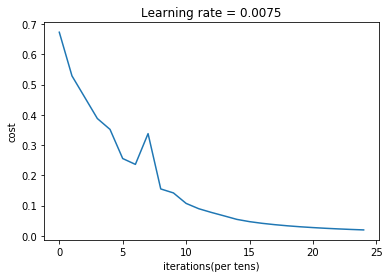

In [29]:
layers_dims = [12288,7,1] # 设置2层的神经网络
parameters = L_layer_model(train_x,train_y,layers_dims,num_iterations=2500,print_cost=True,isPlot=True)

训练完成，我们看一下预测：

In [30]:
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

准确度为：1.0
准确度为：0.76


第 0 次迭代，成本值为： 0.7157315134137129
第 100 次迭代，成本值为： 0.6747377593469114
第 200 次迭代，成本值为： 0.6603365433622127
第 300 次迭代，成本值为： 0.6462887802148751
第 400 次迭代，成本值为： 0.6298131216927771
第 500 次迭代，成本值为： 0.606005622926534
第 600 次迭代，成本值为： 0.5690041263975134
第 700 次迭代，成本值为： 0.519796535043806
第 800 次迭代，成本值为： 0.46415716786282285
第 900 次迭代，成本值为： 0.40842030048298916
第 1000 次迭代，成本值为： 0.37315499216069026
第 1100 次迭代，成本值为： 0.30572374573047106
第 1200 次迭代，成本值为： 0.2681015284774083
第 1300 次迭代，成本值为： 0.23872474827672654
第 1400 次迭代，成本值为： 0.20632263257914718
第 1500 次迭代，成本值为： 0.17943886927493605
第 1600 次迭代，成本值为： 0.1579873581880163
第 1700 次迭代，成本值为： 0.14240413012274492
第 1800 次迭代，成本值为： 0.12865165997888675
第 1900 次迭代，成本值为： 0.1124431499816437
第 2000 次迭代，成本值为： 0.08505631034982421
第 2100 次迭代，成本值为： 0.0575839119861669
第 2200 次迭代，成本值为： 0.044567534546991264
第 2300 次迭代，成本值为： 0.03808275166600256
第 2400 次迭代，成本值为： 0.034410749018419895


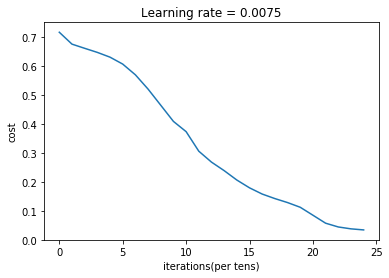

In [31]:
layers_dims = [12288,20,7,5,1] # 设置4层的神经网络
parameters = L_layer_model(train_x,train_y,layers_dims,num_iterations=2500,print_cost=True,isPlot=True)

训练完成，我们看一下预测：

In [32]:
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

准确度为：0.9952153110047847
准确度为：0.78


可以看到在2层网络的时候，测试集的准确率在76%，4层网络的时候，测试集的准确率在78%。

# 分析

我们可以看一看有哪些东西在L层模型中被错误的地标记了，导致准确率没有提高。

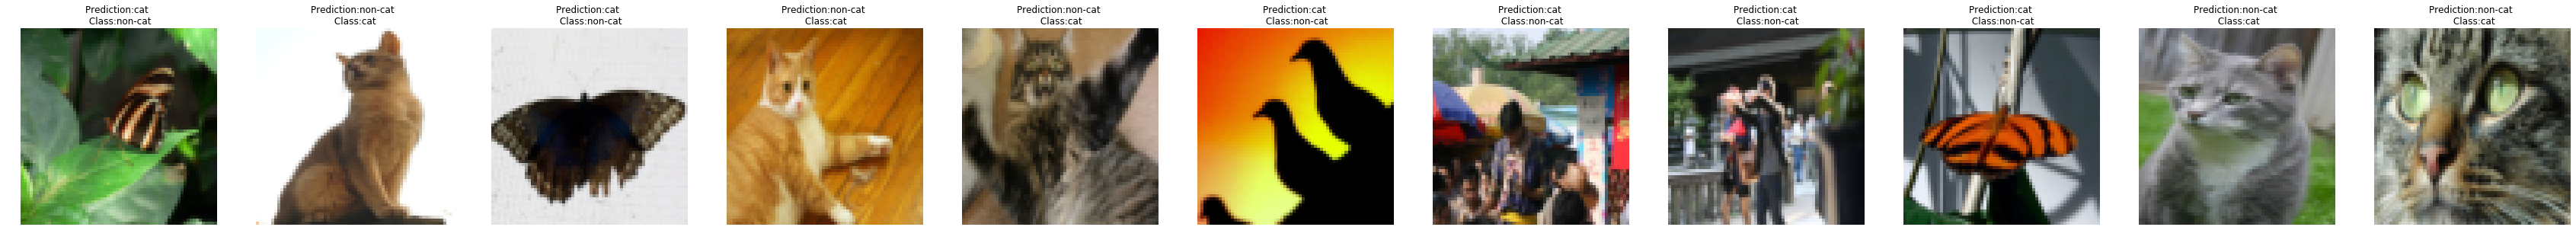

In [36]:
def print_mislabeled_images(classes,X,y,p):
    """
    绘制预测和实际不同的图像
        X - 数据集
        y - 实际的标签
        p - 预测
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a==1))
    plt.rcParams['figure.figsize'] = (60.0,60.0)
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2,num_images,i+1)
        plt.imshow(X[:,index].reshape(64,64,3),interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction:" + classes[int(p[0,index])].decode("utf-8")+" \n Class:" + classes[y[0,index]].decode("utf-8"))
        
print_mislabeled_images(classes,test_x,test_y,pred_test)

分析一下我们就可以得知原因了：
模型往往表现欠佳的几种类型的图像包括：
   - 猫身体在一个不同的位置
   - 猫出现在相似颜色的背景下
   - 不同的猫的颜色和品种
   - 相机角度
   - 图片的亮度
   - 比例变化（猫的图像非常大或很小）

# 选做

我们使用自己的图片试试？

准确度为：1.0
y = 1.0, your L-layer model predicts a "cat" picture.
准确度为：0.0
y = 1.0, your L-layer model predicts a "cat" picture.
准确度为：0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.
准确度为：0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.
准确度为：0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.
准确度为：1.0
y = 1.0, your L-layer model predicts a "cat" picture.
准确度为：1.0
y = 1.0, your L-layer model predicts a "cat" picture.
准确度为：0.0
y = 1.0, your L-layer model predicts a "cat" picture.
准确度为：0.0
y = 1.0, your L-layer model predicts a "cat" picture.
准确度为：1.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


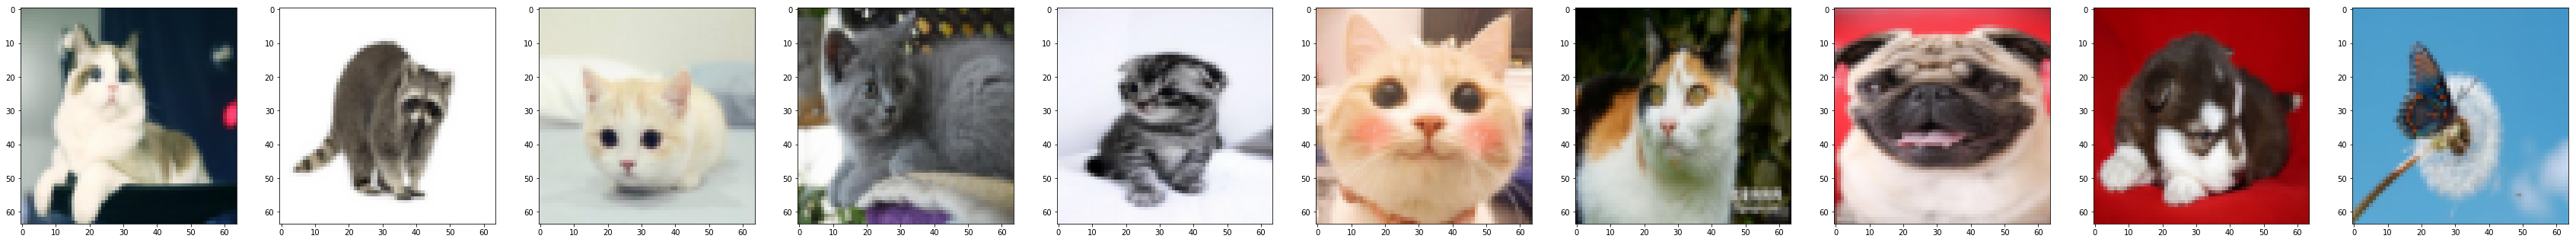

In [71]:
import os
from scipy import misc
import imageio
from skimage import transform
imgs = []
imgs_real_labels = [1,0,1,1,1,1,1,0,0,0]
for root,dirs,files in os.walk(r"D:\Pictures\images"):
    for file in files:
        imgs.append(os.path.join(root,file))

for i in range(0,len(imgs)):
#     image = np.array(ndimage.imread(imgs[i],flatten=False))
#     my_image = misc.imresize(image,size=(num_px,num_px)).reshape((num_px*num_px*3,1))
    
    image = np.array(imageio.imread(imgs[i]))
    image =transform.resize(image, (64, 64))
    my_image=image.reshape(64*64*3,1)
    my_predicted_image = predict(my_image, imgs_real_labels[i], parameters)
    
    plt.subplot(2,len(imgs),i+1)
    plt.imshow(image)
    print("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")